In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

old_opnames = pd.read_csv("../opnames.csv", delimiter=",")
new_opnames = pd.read_csv("../data/validation/opnames.csv", delimiter=";")
new_opnames.head()


,Unnamed: 0,ref_spec,adm_icu,dis_icu,los_icu,age,gender,plan_adm
0,0,INT,2025/01/01 19:16:00,2025/01/02 08:41:00,0.559722,28,M,False
1,1,CAPU,2025/01/01 17:43:00,2025/01/02 12:56:00,0.801388,69,M,False
2,2,CARD,2025/01/02 16:00:00,2025/01/02 17:48:00,0.075694,47,F,False
3,3,CAPU,2025/01/02 00:53:00,2025/01/02 23:03:00,0.924305,33,F,False
4,4,CAPU,2025/01/02 06:25:00,2025/01/03 02:07:00,0.821527,76,M,False


In [2]:
old_opnames.head()

,ref_spec,adm_icu,dis_icu,los_icu,age,gender,nice_ap4_score,icu_death,plan_adm
0,12,2015-10-17 20:22:00,2015-11-03 10:35:00,16.592361,51,F,28,0,0.0
1,12,2015-10-28 23:15:00,2015-11-05 14:46:00,7.646527,54,M,74,0,0.0
2,9,2015-10-30 14:40:00,2015-11-02 14:18:00,2.984722,77,M,63,0,0.0
3,21,2015-10-31 13:24:00,2015-11-16 14:06:00,16.029166,70,F,84,0,0.0
4,12,2015-11-06 01:39:00,2015-11-06 00:08:00,NaN,56,M,49,0,0.0


In [3]:
OPTIONS = {
    "NEC": [12],
    "INT": [2, 4, 7, 41, 47],
    "CARD": [3],
    "CHIR": [9, 10, 11, 13, 39],
    "NEU": [21],
    "CAPU": [29, 50],
    "Other": [15, 18, 19, 20, 23, 36, 48, 98]
}

def get_spec(x):
    if x in OPTIONS.keys():
        return x
    
    parsed_x = int(x)

    for option in OPTIONS.keys():
        if parsed_x in OPTIONS[option]:
            return option
old_opnames["ref_spec"] = old_opnames["ref_spec"].apply(lambda x: get_spec(x))
old_opnames.head()

,ref_spec,adm_icu,dis_icu,los_icu,age,gender,nice_ap4_score,icu_death,plan_adm
0,NEC,2015-10-17 20:22:00,2015-11-03 10:35:00,16.592361,51,F,28,0,0.0
1,NEC,2015-10-28 23:15:00,2015-11-05 14:46:00,7.646527,54,M,74,0,0.0
2,CHIR,2015-10-30 14:40:00,2015-11-02 14:18:00,2.984722,77,M,63,0,0.0
3,NEU,2015-10-31 13:24:00,2015-11-16 14:06:00,16.029166,70,F,84,0,0.0
4,NEC,2015-11-06 01:39:00,2015-11-06 00:08:00,NaN,56,M,49,0,0.0


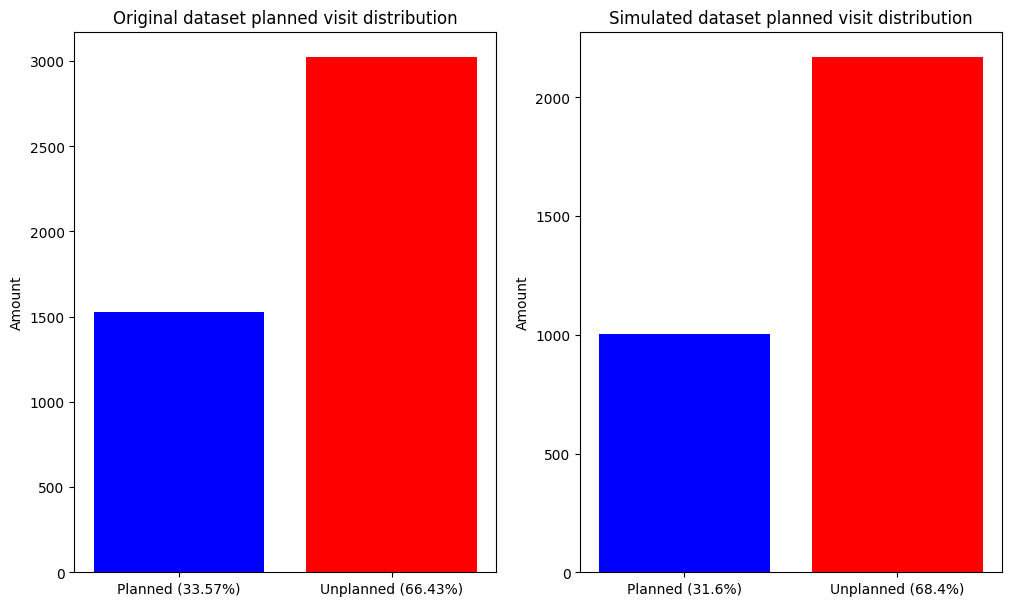

In [4]:
def bar_plot_comparisson(key, value_a, value_b, title, options):

    old_A_count = len(old_opnames[old_opnames[key] == value_a])
    old_B_count = len(old_opnames[old_opnames[key] == value_b])

    old_total = old_A_count + old_B_count

    new_A_count = len(new_opnames[new_opnames[key] == value_a])
    new_B_count = len(new_opnames[new_opnames[key] == value_b])

    new_total = new_A_count + new_B_count

    figure, ax = plt.subplots(1, 2, figsize=(10, 6))

    figure.tight_layout()


    ax[0].bar([f"{options[0]} ({round(old_A_count / old_total * 100, 2)}%)", f"{options[1]} ({round(old_B_count / old_total * 100, 2)}%)"], [old_A_count, old_B_count], color=['blue', 'red'])
    ax[0].set_title(f"Original dataset {title} distribution")
    ax[0].set_ylabel(("Amount"))

    ax[1].bar([f"{options[0]} ({round(new_A_count / new_total * 100, 2)}%)", f"{options[1]} ({round(new_B_count / new_total * 100, 2)}%)"], [new_A_count, new_B_count], color=['blue', 'red'])
    ax[1].set_title(f"Simulated dataset {title} distribution")
    ax[1].set_ylabel(("Amount"))

    figure.subplots_adjust( wspace=0.2, hspace=0.4)


bar_plot_comparisson("plan_adm", 1, 0, "planned visit", ["Planned", "Unplanned"])

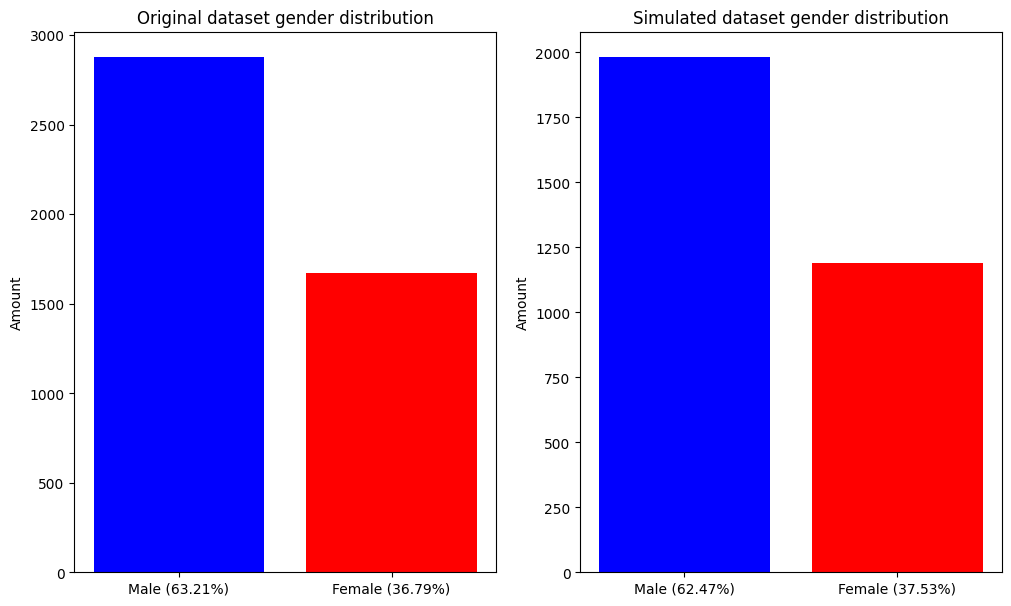

In [5]:
bar_plot_comparisson("gender", "M", "F", "gender", ["Male", "Female"])

In the distributions above we can see that they are almost the same as the original dataset, at least the percentages are. The amounts generated are a bit less but this can be tweaked.

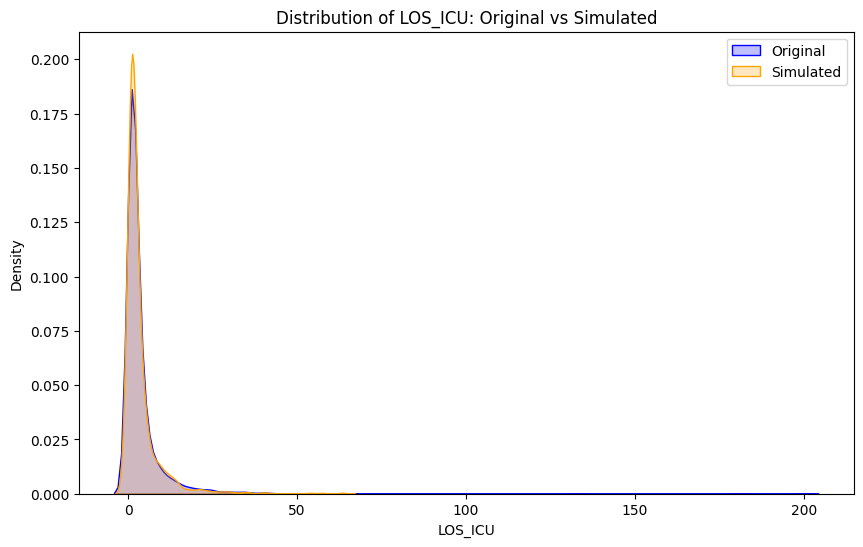

In [6]:
plt.figure(figsize=(10, 6))
sns.kdeplot(old_opnames['los_icu'], label='Original', fill=True, color='blue')
sns.kdeplot(new_opnames['los_icu'], label='Simulated', fill=True, color='orange')
plt.title('Distribution of LOS_ICU: Original vs Simulated')
plt.xlabel('LOS_ICU')
plt.ylabel('Density')
plt.legend()
plt.show()

The graph above shows us that the way the los_icu is distributed over both datasets is roughly the same eventhough the size of the datasets are not the same. We will now move onto verifying whether this is the case when the dataset is split up in to groups corresponding to the ref spec

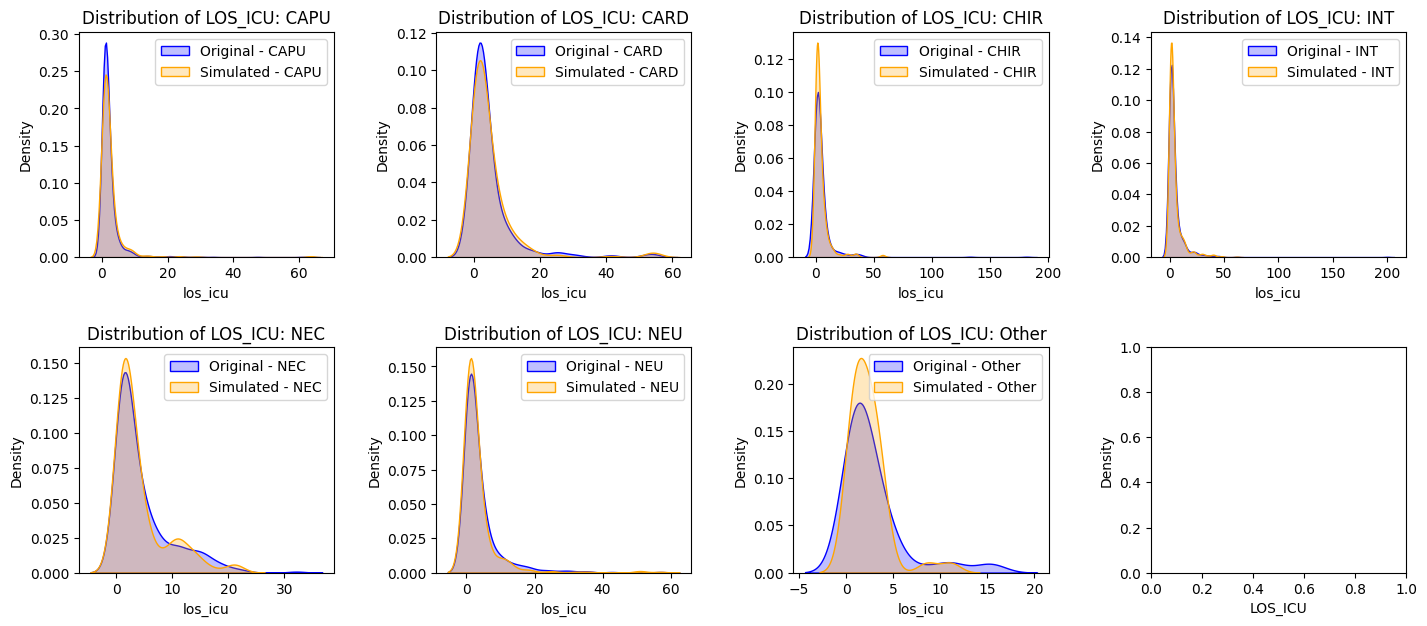

In [7]:
old_opnames_grouped = old_opnames.groupby("ref_spec")
new_opnames_grouped = new_opnames.groupby("ref_spec")

row = 0
col = 0
figure, ax = plt.subplots(2, 4, figsize=(14, 6))

figure.tight_layout()    
for ref_spec in old_opnames_grouped.groups.keys():
    # Check if the group exists in both datasets
    if ref_spec in new_opnames_grouped.groups:
        sns.kdeplot(
            old_opnames_grouped.get_group(ref_spec)['los_icu'], 
            label=f'Original - {ref_spec}',
            ax=ax[row][col],
            fill=True, color='blue'
        )
        sns.kdeplot(
            new_opnames_grouped.get_group(ref_spec)['los_icu'], 
            label=f'Simulated - {ref_spec}', 
            fill=True, color='orange',
            ax=ax[row][col]
        )
        ax[row][col].set_title(f'Distribution of LOS_ICU: {ref_spec}')
        
        ax[row][col].legend()
        
    else:
        print(f"Group {ref_spec} not found in simulated dataset.")

    col += 1
    if col == 4:
        col = 0
        row = 1 

figure.subplots_adjust( wspace=0.4, hspace=0.4)
plt.xlabel('LOS_ICU')
plt.ylabel('Density')
plt.show()

        
    

Last we will verify the bedoccupancy starting from januari first, as thats when we start in our simulation

<Axes: xlabel='date'>

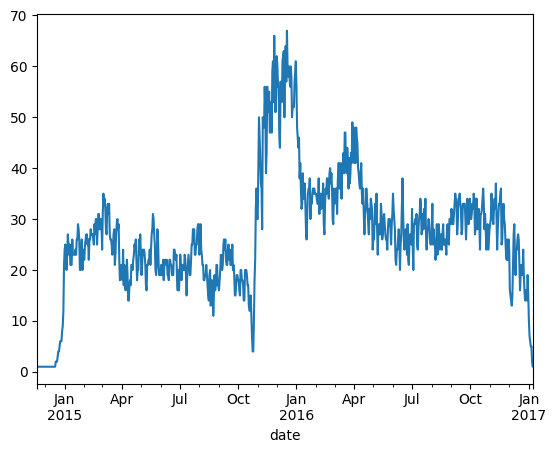

In [10]:
opnames_original = pd.read_csv("../opnames.csv", delimiter=",")
opnames_original = opnames_original.dropna(subset=["los_icu"])
opnames_original["adm_icu"] = pd.to_datetime(opnames_original["adm_icu"])
opnames_original["dis_icu"] = pd.to_datetime(opnames_original["dis_icu"])
opnames_original["adm_icu_date"] = opnames_original["adm_icu"].dt.date
opnames_original["dis_icu_date"] = opnames_original["dis_icu"].dt.date
opnames_original.head()

all_dates = []
for index, row in opnames_original.iterrows():
    dates = pd.date_range(start=row['adm_icu_date'], end=row['dis_icu_date'])
    all_dates.extend(dates)

beds_per_day_original = pd.DataFrame(all_dates, columns=['date'])
bed_occupancy_original = beds_per_day_original['date'].value_counts().sort_index()
bed_occupancy_original.plot.line()

<Axes: xlabel='date'>

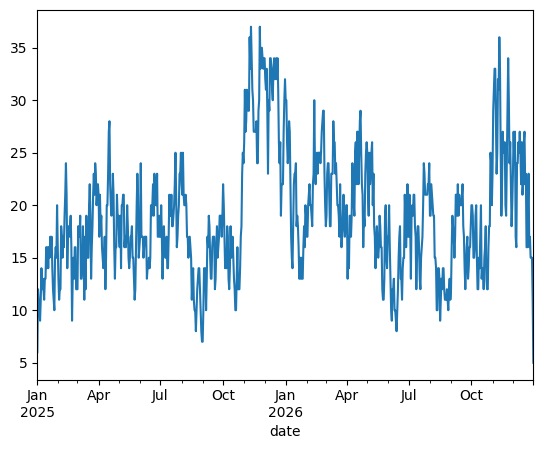

In [14]:
opnames_simulated = pd.read_csv("../data/validation/opnames.csv", delimiter=";")
opnames_simulated["adm_icu"] = pd.to_datetime(opnames_simulated["adm_icu"])
opnames_simulated["dis_icu"] = pd.to_datetime(opnames_simulated["dis_icu"])
opnames_simulated["adm_icu_date"] = opnames_simulated["adm_icu"].dt.date
opnames_simulated["dis_icu_date"] = opnames_simulated["dis_icu"].dt.date
opnames_simulated.head()

all_dates = []
for index, row in opnames_simulated.iterrows():
    dates = pd.date_range(start=row['adm_icu_date'], end=row['dis_icu_date'])
    all_dates.extend(dates)

beds_per_day_simulated = pd.DataFrame(all_dates, columns=['date'])
bed_occupancy_simulated = beds_per_day_simulated['date'].value_counts().sort_index()
bed_occupancy_simulated.plot.line()